In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, LayerNormalization, Embedding, LSTM, GRU, Dense, Bidirectional, TimeDistributed, Input, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard, LambdaCallback
import pandas as pd
import numpy as np
import re
import itertools
import random
from keras_nlp.layers import PositionEmbedding, TokenAndPositionEmbedding
import slot_util as su
import sentence_from_template as sft
from tokenizer import Tokenizer
from data_generator import DataGenerator
import pickle

In [ ]:
TEST_SET = False
SPLIT = 0.2


In [ ]:

# with open("Hotel.txt", encoding='utf-8') as f:
#     templates = f.readlines()
#     templates = [['<sos>'] + line.strip().split(" ") + ['<eos>'] for line in templates]
with open("Charge.txt", encoding='utf-8') as f:
    templates = f.readlines()
    templates = [line.strip().split(" ") for line in templates]

random.shuffle(templates)
num_val_samples = int(SPLIT * len(templates))
if TEST_SET:
    num_train_samples = len(templates) - 2 * num_val_samples
    train_templates = templates[:num_train_samples]
    val_templates = templates[num_train_samples : num_train_samples + num_val_samples]
    test_templates = templates[num_train_samples + num_val_samples :]
else:
    num_train_samples = len(templates) - num_val_samples
    train_templates = templates[:num_train_samples]
    val_templates = templates[num_train_samples : num_train_samples + num_val_samples]
    test_templates = []


print(f"{len(templates)} total templates")
print(f"{len(train_templates)} training templates")
print(f"{len(val_templates)} validation templates")
print(f"{len(test_templates)} test templates")

67 total templates
54 training templates
13 validation templates
0 test templates


In [ ]:
with open("train_data.pickle", "rb") as f:
  train_templates = pickle.load(f)  
with open("validation_data.pickle", "rb") as f:
  val_templates = pickle.load(f) 
if TEST_SET:
  with open("test_data.pickle", "rb") as f:
    test_templates = pickle.load(f)  

In [ ]:
for t in val_templates[:2]:
  print(t)

['شارژ', '{amount}', '{unit}', '{charge_type}', '{operator}', '{for_{me}}', '{verb}']
['{for}', '{device}', '{me}', '{from}', '{account}', '{bnumber}', 'شارژ', '{amount}', '{unit}', '{operator}', '{verb}']


In [ ]:
BATCH_SIZE = 32
MAX_SEQ_LEN = 45
NUM_WORDS = 250
steps_per_epoch=5000
validation_steps=3000
x_tokenizer = Tokenizer(num_words=NUM_WORDS, max_seq_len=MAX_SEQ_LEN, for_sentence=True, sos_eos=False)
y_tokenizer = Tokenizer(num_words=NUM_WORDS, max_seq_len=MAX_SEQ_LEN, for_sentence=False, sos_eos=False)

train_data_gen = DataGenerator(train_templates,
                               x_tokenizer, y_tokenizer,
                               BATCH_SIZE, steps_per_epoch,
                               aug_percent=0.0, max_seq_len=MAX_SEQ_LEN)

val_data_gen = DataGenerator(val_templates,
                             x_tokenizer, y_tokenizer,
                             BATCH_SIZE, validation_steps,
                             aug_percent=0., max_seq_len=MAX_SEQ_LEN)
if TEST_SET:
    test_data_gen = DataGenerator(test_templates,
                                  x_tokenizer, y_tokenizer,
                                  BATCH_SIZE, validation_steps,
                                  aug_percent=0., max_seq_len=MAX_SEQ_LEN)

all words length =  117


In [ ]:
EPOCHS = 3
EMBEDDING_DIM = 300
NUM_UNITS = 150
DENSE_SIZE = 128
VOCAB_SIZE = NUM_WORDS + 50
Y_VOCAB_SIZE = len(y_tokenizer.word_to_index)

inputs = Input(shape=(MAX_SEQ_LEN,))
model = TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=MAX_SEQ_LEN,
    embedding_dim=EMBEDDING_DIM,
)(inputs)
# model = Embedding(
#     input_dim=VOCAB_SIZE,
#     output_dim=EMBEDDING_DIM,
#     input_length=MAX_SEQ_LEN,
# )(inputs)
model = Dropout(0.2)(model)
model = Bidirectional(GRU(NUM_UNITS, activation='elu', return_sequences=True,
                          use_bias=True,
    kernel_regularizer=regularizers.L2(1e-4),# regularizers.L1L2(l1=1e-5, l2=1e-4),
    recurrent_regularizer=regularizers.L2(1e-4),# regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4), # regularizers.L1L2(l1=1e-5, l2=1e-4),
    activity_regularizer=regularizers.L2(1e-5),
    dropout=0.1,
    recurrent_dropout=0.1,
    ))(model)
model = TimeDistributed(Dense(Y_VOCAB_SIZE, activation='softmax'))(model)
model = Model(inputs, model)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision(), Recall(), 'accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 45)]              0         
                                                                 
 token_and_position_embeddin  (None, 45, 300)          103500    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 dropout (Dropout)           (None, 45, 300)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 45, 300)          406800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 45, 12)           3612      
 ibuted)                                                     

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path = "{}_weights.best.hdf5".format('nlu')


checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, 
                                   verbose=1, mode='auto', min_delta=0.0001, cooldown=1, min_lr=0.0001)
callbacks_list = [checkpoint, reduceLROnPlat]

history = model.fit(train_data_gen, 
                    # batch_size = BATCH_SIZE, 
                    epochs = EPOCHS, 
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    validation_data = val_data_gen,
                    callbacks = callbacks_list,)



model.load_weights(weight_path)
model.save('full_nlu_model.h5')

Epoch 1/3
5000/5000 [==============================] - ETA: 0s - loss: 0.0195 - precision: 0.9998 - recall: 0.9968 - accuracy: 0.9983
Epoch 1: val_loss improved from inf to 0.00210, saving model to nlu_weights.best.hdf5
5000/5000 [==============================] - 2397s 478ms/step - loss: 0.0195 - precision: 0.9998 - recall: 0.9968 - accuracy: 0.9983 - val_loss: 0.0021 - val_precision: 1.0000 - val_recall: 1.0000 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/3
5000/5000 [==============================] - ETA: 0s - loss: 0.0016 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000
Epoch 2: val_loss improved from 0.00210 to 0.00137, saving model to nlu_weights.best.hdf5
5000/5000 [==============================] - 2396s 479ms/step - loss: 0.0016 - precision: 1.0000 - recall: 1.0000 - accuracy: 1.0000 - val_loss: 0.0014 - val_precision: 1.0000 - val_recall: 1.0000 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/3
5000/5000 [==============================] - ETA: 0s - loss: 0.0012 - precision:

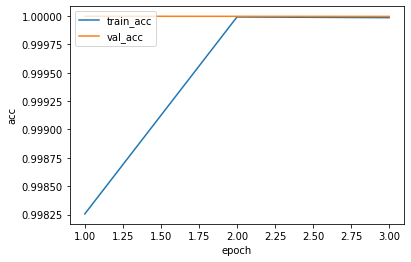

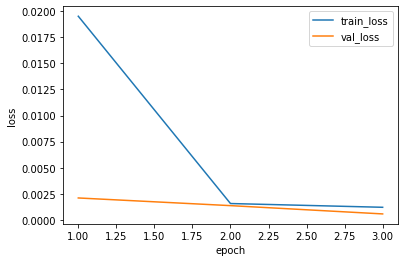

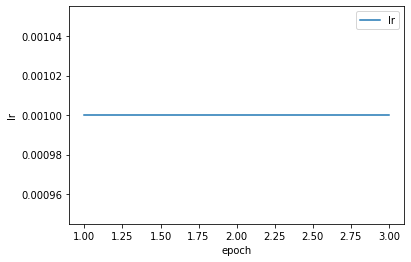

In [ ]:
import matplotlib.pyplot as plt

def plotmodel(history,name):
    # precision = history.history['precision_2']
    # val_precision = history.history['val_precision_2']
    # recall = history.history['recall_2']
    # val_recall = history.history['val_recall_2']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    lrs = history.history['lr']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,acc)#mooth_curve(acc))
    plt.plot(epochs,val_acc)#smooth_curve(val_acc))
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.savefig('acc_'+name+'.png')
    
    plt.figure(2)
    plt.plot(epochs, loss)#smooth_curve(loss))
    plt.plot(epochs,val_loss)#smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.savefig('loss_'+name+'.png')
    
    plt.figure(3)
    plt.plot(epochs, lrs)#,smooth_curve(lrs))
    plt.ylabel('lr')
    plt.xlabel('epoch')
    plt.legend(['lr'], loc='upper right')
    plt.savefig('lr_'+name+'.png')

    # plt.figure(4)                  
    # plt.plot(epochs,precision)#mooth_curve(acc))
    # plt.plot(epochs,val_precision)#smooth_curve(val_acc))
    # plt.ylabel('precision')
    # plt.xlabel('epoch')
    # plt.legend(['train_precision', 'val_precision'], loc='upper left')
    # plt.savefig('precision_'+name+'.png')

    # plt.figure(5)                  
    # plt.plot(epochs,recall)#mooth_curve(acc))
    # plt.plot(epochs,val_recall)#smooth_curve(val_acc))
    # plt.ylabel('recall')
    # plt.xlabel('epoch')
    # plt.legend(['train_recall', 'val_recall'], loc='upper left')
    # plt.savefig('recall_'+name+'.png')
plotmodel(history,'history')


In [ ]:
model.load_weights(weight_path)
model.save('full_nlu_model.h5')

In [ ]:
model_score = model.evaluate(train_data_gen, batch_size=BATCH_SIZE)
model_score = model.evaluate(val_data_gen, batch_size=BATCH_SIZE)
if TEST_SET:
  model_score = model.evaluate(test_data_gen, batch_size=BATCH_SIZE)

In [ ]:

sentence = "یه شارژ 50 تومنی واسم بخر"
input_seq = x_tokenizer.words_to_seq(sentence.split(" "))
prediction = model.predict([input_seq])
slots = [np.argmax(x) for x in prediction[0][:]]
slots = y_tokenizer.seq_to_words(slots)
slots = [s if s != 'OOV' else 'هیچ' for s in slots  ]
print(sentence)
print(slots)
print(list(zip(sentence.split(" "), slots)))

یه شارژ 50 تومنی واسم بخر
['هیچ', 'هیچ', 'amount', 'unit', 'هیچ', 'هیچ']
[('یه', 'هیچ'), ('شارژ', 'هیچ'), ('50', 'amount'), ('تومنی', 'unit'), ('واسم', 'هیچ'), ('بخر', 'هیچ')]


In [ ]:
sentence = "عشقم واسم یه شارژ 5 تومنی اینترنت ایرانسل میگیری برام فدات شم"
input_seq = x_tokenizer.words_to_seq(sentence.split(" "))
prediction = model.predict([input_seq])
slots = [np.argmax(x) for x in prediction[0][:]]
slots = y_tokenizer.seq_to_words(slots)
slots = [s if s != 'OOV' else 'هیچ' for s in slots  ]
print(sentence)
print(slots)
print(list(zip(sentence.split(" "), slots)))

عشقم واسم یه شارژ 5 تومنی اینترنت ایرانسل میگیری برام فدات شم
['pnumber_post', 'هیچ', 'هیچ', 'هیچ', 'amount', 'unit', 'charge_type', 'operator', 'هیچ', 'هیچ', 'pnumber', 'هیچ']
[('عشقم', 'pnumber_post'), ('واسم', 'هیچ'), ('یه', 'هیچ'), ('شارژ', 'هیچ'), ('5', 'amount'), ('تومنی', 'unit'), ('اینترنت', 'charge_type'), ('ایرانسل', 'operator'), ('میگیری', 'هیچ'), ('برام', 'هیچ'), ('فدات', 'pnumber'), ('شم', 'هیچ')]


In [ ]:
sentence = "جون دل شارژ 20 میلیون ریالی همراه اول از حساب 5859831022518434 واسه شماره 09173771786 بخر"
input_seq = x_tokenizer.words_to_seq(sentence.split(" "))
prediction = model.predict([input_seq])
slots = [np.argmax(x) for x in prediction[0][:]]
slots = y_tokenizer.seq_to_words(slots)
slots = [s if s != 'OOV' else 'هیچ' for s in slots  ]
print(sentence)
print(slots)
print(list(zip(sentence.split(" "), slots)))

جون دل شارژ 20 میلیون ریالی همراه اول از حساب 5859831022518434 واسه شماره 09173771786 بخر
['هیچ', 'pnumber', 'هیچ', 'amount', 'unit', 'unit', 'operator', 'operator_post', 'هیچ', 'هیچ', 'bnumber', 'هیچ', 'هیچ', 'pnumber', 'هیچ']
[('جون', 'هیچ'), ('دل', 'pnumber'), ('شارژ', 'هیچ'), ('20', 'amount'), ('میلیون', 'unit'), ('ریالی', 'unit'), ('همراه', 'operator'), ('اول', 'operator_post'), ('از', 'هیچ'), ('حساب', 'هیچ'), ('5859831022518434', 'bnumber'), ('واسه', 'هیچ'), ('شماره', 'هیچ'), ('09173771786', 'pnumber'), ('بخر', 'هیچ')]


In [ ]:
sentence = "آقا لطفا از حساب ملی من برای موبایل 22663377 شارژ رایتل شگفت انگیز 50 تومنی بخر"
input_seq = x_tokenizer.words_to_seq(sentence.split(" "))
prediction = model.predict([input_seq])
slots = [np.argmax(x) for x in prediction[0][:]]
slots = y_tokenizer.seq_to_words(slots)
slots = [s if s != 'OOV' else 'هیچ' for s in slots  ]
print(sentence)
print(slots)
print(list(zip(sentence.split(" "), slots)))

آقا لطفا از حساب ملی من برای موبایل 22663377 شارژ رایتل شگفت انگیز 50 تومنی بخر
['pnumber_post', 'هیچ', 'هیچ', 'هیچ', 'bnumber', 'هیچ', 'هیچ', 'هیچ', 'pnumber', 'هیچ', 'operator', 'charge_type', 'charge_type_post', 'amount', 'unit', 'هیچ']
[('آقا', 'pnumber_post'), ('لطفا', 'هیچ'), ('از', 'هیچ'), ('حساب', 'هیچ'), ('ملی', 'bnumber'), ('من', 'هیچ'), ('برای', 'هیچ'), ('موبایل', 'هیچ'), ('22663377', 'pnumber'), ('شارژ', 'هیچ'), ('رایتل', 'operator'), ('شگفت', 'charge_type'), ('انگیز', 'charge_type_post'), ('50', 'amount'), ('تومنی', 'unit'), ('بخر', 'هیچ')]


In [ ]:
sentence = "برای شماره سبا شارژ اینترنت 50 تومنی کارت به کارت کن از کارت 59595949549"
input_seq = x_tokenizer.words_to_seq(sentence.split(" "))
prediction = model.predict([input_seq])
slots = [np.argmax(x) for x in prediction[0][:]]
slots = y_tokenizer.seq_to_words(slots)
slots = [s if s != 'OOV' else 'هیچ' for s in slots  ]
print(sentence)
print(slots)
print(list(zip(sentence.split(" "), slots)))

برای شماره سبا شارژ اینترنت 50 تومنی کارت به کارت کن از کارت 59595949549
['هیچ', 'هیچ', 'pnumber', 'هیچ', 'charge_type', 'amount', 'unit', 'هیچ', 'هیچ', 'هیچ', 'هیچ', 'هیچ', 'هیچ', 'bnumber']
[('برای', 'هیچ'), ('شماره', 'هیچ'), ('سبا', 'pnumber'), ('شارژ', 'هیچ'), ('اینترنت', 'charge_type'), ('50', 'amount'), ('تومنی', 'unit'), ('کارت', 'هیچ'), ('به', 'هیچ'), ('کارت', 'هیچ'), ('کن', 'هیچ'), ('از', 'هیچ'), ('کارت', 'هیچ'), ('59595949549', 'bnumber')]


In [ ]:
sentence = "لطفا شارژ رایتل شگفت انگیز به مبلغ 50 تومن از حساب 5868 بگیر واسم برای شماره تلفن همراه آرمین خیاطی"
input_seq = x_tokenizer.words_to_seq(sentence.split(" "))
prediction = model.predict([input_seq])
slots = [np.argmax(x) for x in prediction[0][:]]
slots = y_tokenizer.seq_to_words(slots)
slots = [s if s != 'OOV' else 'هیچ' for s in slots  ]
print(sentence)
print(slots)
print(list(zip(sentence.split(" "), slots)))

لطفا شارژ رایتل شگفت انگیز به مبلغ 50 تومن از حساب 5868 بگیر واسم برای شماره تلفن همراه آرمین خیاطی
['هیچ', 'هیچ', 'operator', 'charge_type', 'charge_type_post', 'هیچ', 'هیچ', 'amount', 'unit', 'هیچ', 'هیچ', 'bnumber', 'هیچ', 'هیچ', 'هیچ', 'هیچ', 'هیچ', 'هیچ', 'pnumber', 'pnumber_post']
[('لطفا', 'هیچ'), ('شارژ', 'هیچ'), ('رایتل', 'operator'), ('شگفت', 'charge_type'), ('انگیز', 'charge_type_post'), ('به', 'هیچ'), ('مبلغ', 'هیچ'), ('50', 'amount'), ('تومن', 'unit'), ('از', 'هیچ'), ('حساب', 'هیچ'), ('5868', 'bnumber'), ('بگیر', 'هیچ'), ('واسم', 'هیچ'), ('برای', 'هیچ'), ('شماره', 'هیچ'), ('تلفن', 'هیچ'), ('همراه', 'هیچ'), ('آرمین', 'pnumber'), ('خیاطی', 'pnumber_post')]


In [ ]:
sentence = "لطفا شارژ رایتل شگفت انگیز به مبلغ 50 تومن از حساب 5868 بگیر واسم برای شماره تلفن همراه آرمین خیاطی سریع فقط باشه مرسی"
input_seq = x_tokenizer.words_to_seq(sentence.split(" "))
prediction = model.predict([input_seq])
slots = [np.argmax(x) for x in prediction[0][:]]
slots = y_tokenizer.seq_to_words(slots)
slots = [s if s != 'OOV' else 'هیچ' for s in slots  ]
print(sentence)
print(slots)
print(list(zip(sentence.split(" "), slots)))

لطفا شارژ رایتل شگفت انگیز به مبلغ 50 تومن از حساب 5868 بگیر واسم برای شماره تلفن همراه آرمین خیاطی سریع فقط باشه مرسی
['هیچ', 'هیچ', 'operator', 'charge_type', 'charge_type_post', 'هیچ', 'هیچ', 'amount', 'unit', 'هیچ', 'هیچ', 'bnumber', 'هیچ', 'هیچ', 'هیچ', 'هیچ', 'هیچ', 'هیچ', 'pnumber', 'pnumber_post', 'pnumber_post', 'pnumber_post', 'pnumber_post', 'pnumber_post']
[('لطفا', 'هیچ'), ('شارژ', 'هیچ'), ('رایتل', 'operator'), ('شگفت', 'charge_type'), ('انگیز', 'charge_type_post'), ('به', 'هیچ'), ('مبلغ', 'هیچ'), ('50', 'amount'), ('تومن', 'unit'), ('از', 'هیچ'), ('حساب', 'هیچ'), ('5868', 'bnumber'), ('بگیر', 'هیچ'), ('واسم', 'هیچ'), ('برای', 'هیچ'), ('شماره', 'هیچ'), ('تلفن', 'هیچ'), ('همراه', 'هیچ'), ('آرمین', 'pnumber'), ('خیاطی', 'pnumber_post'), ('سریع', 'pnumber_post'), ('فقط', 'pnumber_post'), ('باشه', 'pnumber_post'), ('مرسی', 'pnumber_post')]


In [ ]:
sentence = "لطفا شارژ رایتل شگفت انگیز به مبلغ 50 تومن برای شماره تلفن همراه آرمین خیاطی سریع فقط باشه مرسی از حساب 5868 بگیر واسم"
input_seq = x_tokenizer.words_to_seq(sentence.split(" "))
prediction = model.predict([input_seq])
slots = [np.argmax(x) for x in prediction[0][:]]
slots = y_tokenizer.seq_to_words(slots)
slots = [s if s != 'OOV' else 'هیچ' for s in slots  ]
print(sentence)
print(slots)
print(list(zip(sentence.split(" "), slots)))

لطفا شارژ رایتل شگفت انگیز به مبلغ 50 تومن برای شماره تلفن همراه آرمین خیاطی سریع فقط باشه مرسی از حساب 5868 بگیر واسم
['هیچ', 'هیچ', 'operator', 'charge_type', 'charge_type_post', 'هیچ', 'هیچ', 'amount', 'unit', 'هیچ', 'هیچ', 'هیچ', 'هیچ', 'pnumber', 'pnumber_post', 'pnumber_post', 'pnumber_post', 'pnumber_post', 'pnumber_post', 'هیچ', 'هیچ', 'bnumber', 'هیچ', 'هیچ']
[('لطفا', 'هیچ'), ('شارژ', 'هیچ'), ('رایتل', 'operator'), ('شگفت', 'charge_type'), ('انگیز', 'charge_type_post'), ('به', 'هیچ'), ('مبلغ', 'هیچ'), ('50', 'amount'), ('تومن', 'unit'), ('برای', 'هیچ'), ('شماره', 'هیچ'), ('تلفن', 'هیچ'), ('همراه', 'هیچ'), ('آرمین', 'pnumber'), ('خیاطی', 'pnumber_post'), ('سریع', 'pnumber_post'), ('فقط', 'pnumber_post'), ('باشه', 'pnumber_post'), ('مرسی', 'pnumber_post'), ('از', 'هیچ'), ('حساب', 'هیچ'), ('5868', 'bnumber'), ('بگیر', 'هیچ'), ('واسم', 'هیچ')]


In [ ]:
sentence = "شارژ شگفت انگیز ایرنسل 50 هزار تومنی"
input_seq = x_tokenizer.words_to_seq(sentence.split(" "))
prediction = model.predict([input_seq])
slots = [np.argmax(x) for x in prediction[0][:]]
slots = y_tokenizer.seq_to_words(slots)
slots = [s if s != 'OOV' else 'هیچ' for s in slots  ]
print(sentence)
print(slots)
print(list(zip(sentence.split(" "), slots)))

شارژ شگفت انگیز ایرنسل 50 هزار تومنی
['هیچ', 'charge_type', 'charge_type_post', 'amount', 'amount', 'unit', 'unit']
[('شارژ', 'هیچ'), ('شگفت', 'charge_type'), ('انگیز', 'charge_type_post'), ('ایرنسل', 'amount'), ('50', 'amount'), ('هزار', 'unit'), ('تومنی', 'unit')]


In [ ]:
sentence = "برای شماره 0918383838 از حساب 9494949 شارژ 90 تومنی همراه اول کارت به کارت کن"
input_seq = x_tokenizer.words_to_seq(sentence.split(" "))
prediction = model.predict([input_seq])
slots = [np.argmax(x) for x in prediction[0][:]]
slots = y_tokenizer.seq_to_words(slots)
slots = [s if s != 'OOV' else 'هیچ' for s in slots  ]
print(sentence)
print(slots)
print(list(zip(sentence.split(" "), slots)))

برای شماره 0918383838 از حساب 9494949 شارژ 90 تومنی همراه اول کارت به کارت کن
['هیچ', 'هیچ', 'pnumber', 'هیچ', 'هیچ', 'bnumber', 'هیچ', 'amount', 'unit', 'operator', 'operator_post', 'هیچ', 'هیچ', 'هیچ', 'هیچ']
[('برای', 'هیچ'), ('شماره', 'هیچ'), ('0918383838', 'pnumber'), ('از', 'هیچ'), ('حساب', 'هیچ'), ('9494949', 'bnumber'), ('شارژ', 'هیچ'), ('90', 'amount'), ('تومنی', 'unit'), ('همراه', 'operator'), ('اول', 'operator_post'), ('کارت', 'هیچ'), ('به', 'هیچ'), ('کارت', 'هیچ'), ('کن', 'هیچ')]


In [ ]:
sentence = "واسم شارژ همراه اول 50 تومنی بخر از کارت 84949494 برای خط سبا"
input_seq = x_tokenizer.words_to_seq(sentence.split(" "))
prediction = model.predict([input_seq])
slots = [np.argmax(x) for x in prediction[0][:]]
slots = y_tokenizer.seq_to_words(slots)
slots = [s if s != 'OOV' else 'هیچ' for s in slots  ]
print(sentence)
print(slots)
print(list(zip(sentence.split(" "), slots)))

واسم شارژ همراه اول 50 تومنی بخر از کارت 84949494 برای خط سبا
['هیچ', 'هیچ', 'operator', 'operator_post', 'amount', 'unit', 'هیچ', 'هیچ', 'هیچ', 'bnumber', 'هیچ', 'هیچ', 'pnumber']
[('واسم', 'هیچ'), ('شارژ', 'هیچ'), ('همراه', 'operator'), ('اول', 'operator_post'), ('50', 'amount'), ('تومنی', 'unit'), ('بخر', 'هیچ'), ('از', 'هیچ'), ('کارت', 'هیچ'), ('84949494', 'bnumber'), ('برای', 'هیچ'), ('خط', 'هیچ'), ('سبا', 'pnumber')]


In [ ]:
sentence = "واسم شارژ همراه اول 50 تومنی بخر از کارت     84949494 برای خط سبا"
inp =sentence.strip().split(" ")
inp = [w for w in inp if w != '']
input_seq = x_tokenizer.words_to_seq(inp)
prediction = model.predict([input_seq])
slots = [np.argmax(x) for x in prediction[0][:]]
slots = y_tokenizer.seq_to_words(slots)
slots = [s if s != 'OOV' else 'هیچ' for s in slots  ]
print(sentence)
print(slots)
print(list(zip(inp, slots)))

واسم شارژ همراه اول 50 تومنی بخر از کارت     84949494 برای خط سبا
['هیچ', 'هیچ', 'operator', 'operator_post', 'amount', 'unit', 'هیچ', 'هیچ', 'هیچ', 'bnumber', 'هیچ', 'هیچ', 'pnumber']
[('واسم', 'هیچ'), ('شارژ', 'هیچ'), ('همراه', 'operator'), ('اول', 'operator_post'), ('50', 'amount'), ('تومنی', 'unit'), ('بخر', 'هیچ'), ('از', 'هیچ'), ('کارت', 'هیچ'), ('84949494', 'bnumber'), ('برای', 'هیچ'), ('خط', 'هیچ'), ('سبا', 'pnumber')]


In [ ]:
import pickle

with open("x_tokenizer.pickle", "wb") as f:
  pickle.dump(x_tokenizer, f)
with open("y_tokenizer.pickle", "wb") as f:
  pickle.dump(y_tokenizer, f)  

with open("train_data.pickle", "wb") as f:
  pickle.dump(train_templates, f)  
with open("validation_data.pickle", "wb") as f:
  pickle.dump(val_templates, f) 
if TEST_SET:
  with open("test_data.pickle", "wb") as f:
    pickle.dump(test_templates, f)  